{'accuracy': 0.38666666666666666, 'avg_latency': 0.314, 'n': 150}


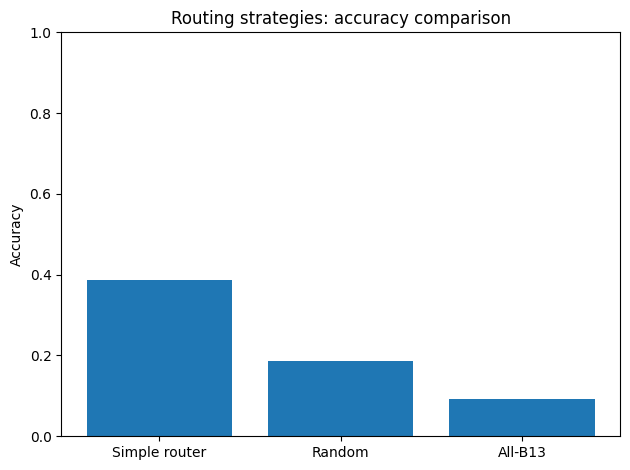

Avg latency (relative units):
  Simple router: 0.314
  Random       : 0.356
  All-B13     : 0.350


In [3]:
import re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# Model catalog & lookup maps
# --------------------------
MODELS = ["WB7","K7","M7","B13","R32"]
LAT_MAP = {"WB7":0.20, "K7":0.25, "M7":0.30, "B13":0.35, "R32":0.70}
COST_MAP = {"WB7":1.00, "K7":1.10, "M7":1.30, "B13":1.60, "R32":3.00}

# ---------------------------------
# Very simple text-only heuristic router
# (no metadata needed; uses only 'question')
# ---------------------------------
def _is_ko(text: str) -> bool:
    # Any Hangul character → treat as Korean
    return any(0xAC00 <= ord(ch) <= 0xD7A3 for ch in text)

def _looks_math(text: str) -> bool:
    # Easy patterns: digits with operators OR common math/LaTeX tokens
    return bool(
        re.search(r"\d+\s*[\+\-\*\/\^]\s*\d+", text) or
        re.search(r"\\(frac|sum|sqrt)|∫|Σ|π", text) or
        re.search(r"\b(integral|derivative|theorem|prove|equation)\b", text, re.I)
    )

def _very_hard_math(text: str) -> bool:
    # Escalate to R32 for "prove/theorem" style or very long math statements
    return bool(
        re.search(r"\b(prove|theorem|lemma|show that)\b", text, re.I) or
        (len(text) > 600 and _looks_math(text))
    )

def _is_long(text: str, thresh: int = 280) -> bool:
    return len(text) >= thresh

def simple_text_router(question: str) -> str:
    """
    Returns one of: 'WB7','K7','M7','B13','R32'
    Priority:
      1) ko language -> K7 (unless clearly math; then M7)
      2) math -> M7 (or R32 if very-hard-math)
      3) long english -> B13
      4) otherwise -> WB7
    """
    q = question or ""
    if _is_ko(q):
        # Korean math goes to Math model (M7); else ko general -> K7
        return "M7" if _looks_math(q) else "K7"
    # English
    if _looks_math(q):
        return "R32" if _very_hard_math(q) else "M7"
    if _is_long(q):
        return "B13"
    return "WB7"

# --------------------------
# (3) Add prediction column to TEST
# --------------------------
def add_predictions(test_df: pd.DataFrame, text_col: str = "question", pred_col: str = "prediction") -> pd.DataFrame:
    test_df = test_df.copy()
    test_df[pred_col] = test_df[text_col].astype(str).map(simple_text_router)
    return test_df

# ---------------------------------------------
# (4) Evaluate: accuracy (vs gold) and latency
# ---------------------------------------------
def evaluate_accuracy_latency(
    df: pd.DataFrame,
    pred_col: str = "prediction",
    gold_col: str = "route_rule",
    lat_map: dict = LAT_MAP
) -> dict:
    if gold_col not in df.columns:
        raise ValueError(f"Gold column '{gold_col}' is missing from the DataFrame.")
    if pred_col not in df.columns:
        raise ValueError(f"Prediction column '{pred_col}' is missing from the DataFrame.")
    acc = float((df[pred_col] == df[gold_col]).mean())
    avg_latency = float(df[pred_col].map(lat_map).mean())
    return {"accuracy": acc, "avg_latency": avg_latency, "n": int(len(df))}

# ----------------------------------------------------------
# (5) Plot: simple-router vs random vs single-model baseline
# ----------------------------------------------------------
def compare_policies_plot(
    test_df: pd.DataFrame,
    gold_col: str = "route_rule",
    single_model: str = "B13",
    pred_col: str = "prediction",
    seed: int = 42
):
    rng = random.Random(seed)

    # A) Our simple router (ensure predictions exist)
    if pred_col not in test_df.columns:
        test_df = add_predictions(test_df, pred_col=pred_col)
    m_ours = evaluate_accuracy_latency(test_df, pred_col=pred_col, gold_col=gold_col)

    # B) Random guessing among the 5 models (uniform)
    rand_preds = [rng.choice(MODELS) for _ in range(len(test_df))]
    df_rand = test_df.copy()
    df_rand["rand_pred"] = rand_preds
    m_rand = evaluate_accuracy_latency(df_rand, pred_col="rand_pred", gold_col=gold_col)

    # C) Single-model baseline (always choose one model)
    df_one = test_df.copy()
    df_one["one_pred"] = single_model
    m_one = evaluate_accuracy_latency(df_one, pred_col="one_pred", gold_col=gold_col)

    # Prepare bar plot for ACCURACY (primary ask)
    labels = ["Simple router", "Random", f"All-{single_model}"]
    accuracies = [m_ours["accuracy"], m_rand["accuracy"], m_one["accuracy"]]

    plt.figure()
    plt.bar(labels, accuracies)
    plt.ylabel("Accuracy")
    plt.title("Routing strategies: accuracy comparison")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    # (Optional) Print latencies for completeness
    print("Avg latency (relative units):")
    print(f"  Simple router: {m_ours['avg_latency']:.3f}")
    print(f"  Random       : {m_rand['avg_latency']:.3f}")
    print(f"  All-{single_model: <8}: {m_one['avg_latency']:.3f}")

    return {"ours": m_ours, "random": m_rand, "all_one": m_one}


train = pd.read_csv('train_koen_router_bench.csv')
test = train.sample(150)
test = add_predictions(test, pred_col="prediction")         # step (3)
metrics = evaluate_accuracy_latency(test, "prediction", "route_rule")  # step (4)
print(metrics)
results = compare_policies_plot(test, gold_col="route_rule", single_model="B13")  # step (5)

{'accuracy': 0.3933333333333333, 'avg_latency': 0.3173333333333334, 'n': 150}


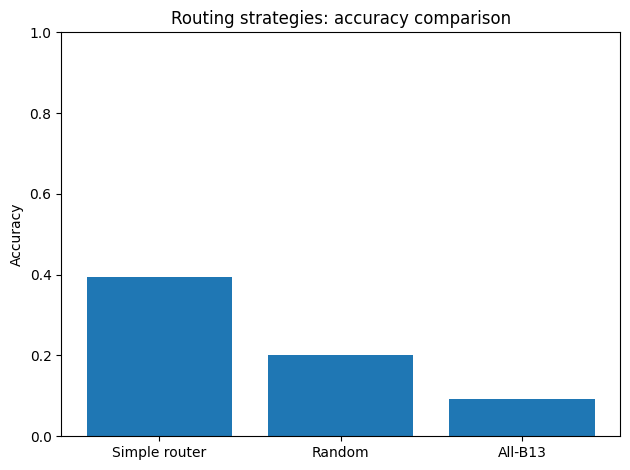

Avg latency (relative units):
  Simple router: 0.317
  Random       : 0.356
  All-B13     : 0.350


In [4]:

train = pd.read_csv('train_koen_router_bench.csv')
test = train.sample(150)
test = add_predictions(test, pred_col="prediction")         # step (3)
metrics = evaluate_accuracy_latency(test, "prediction", "route_rule")  # step (4)
print(metrics)
results = compare_policies_plot(test, gold_col="route_rule", single_model="B13")  # step (5)

In [5]:
test = pd.read_csv('test_koen_router_bench_wo_oracle.csv')
test = add_predictions(test, pred_col="prediction")

In [6]:
test

,question,prediction
0,Define pure competition.\n1) Pure competition ...,B13
1,3주 전 자연분만한 37세 산모가 기운이 없고 땀이 많아서 병원에 왔다. 가만히 있...,K7
2,When a block of wood of mass 1 kg is held in a...,B13
3,Oxygenated blood is carried to the heart by wh...,WB7
4,A landowner owned a large building in the city...,B13
...,...,...
2495,"A chemist possessesKCl, PH_3, GeCl_4, H_2S, an...",WB7
2496,"\(\iint_D \frac{|y|}{\sqrt{(x-2)^2+y^2}}dxdy, ...",M7
2497,An epidemic involving 10 individuals of all ag...,B13
2498,An American buys an entertainment system that ...,B13


In [7]:
# ==========================
# New and more diverse routers
# ==========================
import re, random
from dataclasses import dataclass
from typing import List, Optional, Dict, Any

import numpy as np

# Try to reuse the user's globals if they exist
try:
    MODELS
except NameError:
    MODELS = ["WB7","K7","M7","B13","R32"]

try:
    LAT_MAP
except NameError:
    LAT_MAP = {"WB7":0.20, "K7":0.25, "M7":0.30, "B13":0.35, "R32":0.70}

try:
    COST_MAP
except NameError:
    COST_MAP = {"WB7":1.00, "K7":1.10, "M7":1.30, "B13":1.60, "R32":3.00}

# --------------------------
# Base class for uniform API
# --------------------------
class BaseRouter:
    name = "base"

    def fit(self, train_df, text_col: str = "question", label_col: str = "route_rule"):
        return self

    def predict_one(self, text: str) -> str:
        raise NotImplementedError

    def predict_many(self, texts) -> List[str]:
        return [self.predict_one(t) for t in texts]

# ------------------------------------------
# 1) RegexRouterV2: richer text heuristics
# ------------------------------------------
class RegexRouterV2(BaseRouter):
    name = "regex_v2"

    def __init__(self, long_thresh: int = 280):
        self.long_thresh = long_thresh
        # Math signal: LaTeX tokens, operators, math words
        self.re_math = re.compile(
            r"(\d+\s*[\+\-\*/\^]\s*\d+)|"                # a op b
            r"(\\(frac|sum|sqrt|int|lim)|∫|Σ|π|∞)|"       # LaTeX and symbols
            r"\b(limit|integral|derivative|theorem|lemma|proof|prove|equation|solve)\b",
            re.I,
        )
        # Very hard math cues
        self.re_very_hard = re.compile(r"\b(prove|theorem|lemma|show that|rigorous)\b", re.I)
        # Code cues
        self.re_code = re.compile(
            r"```|#include|using\s+namespace|int\s+main|def\s+\w+\(|class\s+\w+\:|"
            r"public\s+static\s+void\s+main|System\.out\.println|console\.log|TypeError|Traceback|NullReference",
            re.I,
        )
        # SQL or data cues
        self.re_sql = re.compile(r"\b(SELECT|UPDATE|INSERT|DELETE|JOIN|GROUP BY|WHERE)\b", re.I)
        # JSON or config look
        self.re_jsonish = re.compile(r"\{[^}]*:\s*[^}]*\}")
        # Hangul ranges: Jamo and Syllables
        self._is_ko = lambda s: any(0xAC00 <= ord(ch) <= 0xD7A3 or 0x1100 <= ord(ch) <= 0x11FF for ch in s)

    def _is_long(self, s: str) -> bool:
        return len(s) >= self.long_thresh

    def _math_density(self, s: str) -> float:
        if not s:
            return 0.0
        digits = sum(ch.isdigit() for ch in s)
        ops = sum(ch in "+-*/^=" for ch in s)
        n = len(s)
        return (digits + ops) / max(1, n)

    def predict_one(self, text: str) -> str:
        s = text or ""
        ko = self._is_ko(s)
        looks_math = bool(self.re_math.search(s)) or self._math_density(s) > 0.06
        very_hard = bool(self.re_very_hard.search(s)) or (len(s) > 600 and looks_math)
        looks_code = bool(self.re_code.search(s) or self.re_sql.search(s) or self.re_jsonish.search(s))
        is_long = self._is_long(s)

        if ko:
            # Korean math uses M7 else K7
            if looks_math:
                return "M7" if not very_hard else "R32"
            return "K7" if not looks_code else "B13"

        # English and others
        if looks_math:
            return "R32" if very_hard else "M7"

        if looks_code:
            # Default to bigger general model for code or stack traces
            return "B13" if not is_long else "R32"

        if is_long:
            return "B13"

        # Short and general
        return "WB7"

# -------------------------------------------------------
# 2) CostAwareRegex: latency aware tweak of RegexRouterV2
#    It tries to step down to a cheaper neighbor when safe
# -------------------------------------------------------
class CostAwareRegex(BaseRouter):
    name = "cost_aware_regex"

    def __init__(self, base=None, stepdown_ok_for: Optional[Dict[str, str]] = None):
        self.base = base or RegexRouterV2()
        # Map heavy model to the cheaper fallback that usually still works
        self.stepdown_ok_for = stepdown_ok_for or {"B13": "WB7", "R32": "B13", "M7": "WB7"}

    def fit(self, train_df, text_col: str = "question", label_col: str = "route_rule"):
        # Could learn safe stepdowns from train_df later if desired
        return self

    def predict_one(self, text: str) -> str:
        raw = self.base.predict_one(text)
        s = text or ""
        # If very short and not clearly math or code, allow a stepdown
        is_short = len(s) < 120
        maybe_math = bool(self.base.re_math.search(s))
        maybe_code = bool(self.base.re_code.search(s) or self.base.re_sql.search(s) or self.base.re_jsonish.search(s))
        if is_short and not maybe_math and not maybe_code and raw in self.stepdown_ok_for:
            return self.stepdown_ok_for[raw]
        return raw

# ----------------------------------------------------------
# 3) kNN example router: TF‑IDF over char n‑grams + kNN vote
# ----------------------------------------------------------
class KNNRouter(BaseRouter):
    name = "knn_char"

    def __init__(self, n_neighbors: int = 25, min_df: int = 2, char_ngrams=(3, 5), seed: int = 13):
        self.n_neighbors = n_neighbors
        self.min_df = min_df
        self.char_ngrams = char_ngrams
        self.seed = seed
        self.vectorizer = None
        self.clf = None
        self.classes_ = None

    def fit(self, train_df, text_col: str = "question", label_col: str = "route_rule"):
        try:
            from sklearn.feature_extraction.text import TfidfVectorizer
            from sklearn.neighbors import KNeighborsClassifier
        except Exception as e:
            raise RuntimeError("scikit-learn is required for KNNRouter") from e

        X_text = train_df[text_col].astype(str).tolist()
        y = train_df[label_col].astype(str).values
        self.vectorizer = TfidfVectorizer(analyzer="char", ngram_range=self.char_ngrams, min_df=self.min_df)
        X = self.vectorizer.fit_transform(X_text)
        # Use distance weighting. With L2 normalized TF‑IDF this approximates cosine voting reasonably well.
        self.clf = KNeighborsClassifier(n_neighbors=self.n_neighbors, weights="distance")
        self.clf.fit(X, y)
        self.classes_ = np.unique(y)
        return self

    def predict_one(self, text: str) -> str:
        if self.vectorizer is None or self.clf is None:
            raise RuntimeError("Call fit first")
        X = self.vectorizer.transform([text or ""])
        return self.clf.predict(X)[0]

# --------------------------------------------------------------------
# 4) LinearModelRouter: n‑gram TF‑IDF + light numeric features + LR
# --------------------------------------------------------------------
class TextStatsFeaturizer:
    """Light numeric features returned as a sparse CSR matrix."""
    def __init__(self):
        # Precompile small regexes
        self.re_code = re.compile(
            r"```|def\s+\w+\(|class\s+\w+\:|console\.log|TypeError|Traceback|SELECT|INSERT|UPDATE|DELETE|JOIN|GROUP BY",
            re.I,
        )
        self.re_math = re.compile(
            r"(\d+\s*[\+\-\*/\^]\s*\d+)|"
            r"(\\(frac|sum|sqrt|int|lim)|∫|Σ|π|∞)|"
            r"\b(limit|integral|derivative|theorem|lemma|proof|prove|equation|solve)\b",
            re.I,
        )

    def transform(self, texts: List[str]):
        from scipy import sparse
        feats = []
        for s in texts:
            t = s if isinstance(s, str) else ""
            n = len(t)
            if n == 0:
                n = 1
            digits = sum(ch.isdigit() for ch in t) / n
            upper = sum(ch.isupper() for ch in t) / n
            symbols = sum(ch in "{}[]()$^*_+=<>|/~`" for ch in t) / n
            hangul = sum(0xAC00 <= ord(ch) <= 0xD7A3 or 0x1100 <= ord(ch) <= 0x11FF for ch in t) / n
            has_code = 1.0 if self.re_code.search(t) else 0.0
            has_math = 1.0 if self.re_math.search(t) else 0.0
            is_long = 1.0 if len(t) >= 280 else 0.0
            feats.append([len(t), digits, upper, symbols, hangul, has_code, has_math, is_long])
        arr = np.array(feats, dtype=float)
        return sparse.csr_matrix(arr)

class LinearModelRouter(BaseRouter):
    name = "linear_ngram"

    def __init__(self, min_df_word=2, min_df_char=2, char_ngrams=(3,5), C=2.0, max_iter=400, seed: int = 13):
        self.min_df_word = min_df_word
        self.min_df_char = min_df_char
        self.char_ngrams = char_ngrams
        self.C = C
        self.max_iter = max_iter
        self.seed = seed
        self.vec_word = None
        self.vec_char = None
        self.stats = TextStatsFeaturizer()
        self.clf = None
        self.classes_ = None

    def fit(self, train_df, text_col: str = "question", label_col: str = "route_rule"):
        try:
            from sklearn.feature_extraction.text import TfidfVectorizer
            from sklearn.linear_model import LogisticRegression
            from scipy import sparse
        except Exception as e:
            raise RuntimeError("scikit-learn is required for LinearModelRouter") from e

        X_text = train_df[text_col].astype(str).tolist()
        y = train_df[label_col].astype(str).values

        self.vec_word = TfidfVectorizer(analyzer="word", ngram_range=(1,2), min_df=self.min_df_word)
        self.vec_char = TfidfVectorizer(analyzer="char", ngram_range=self.char_ngrams, min_df=self.min_df_char)

        Xw = self.vec_word.fit_transform(X_text)
        Xc = self.vec_char.fit_transform(X_text)
        Xs = self.stats.transform(X_text)

        X = sparse.hstack([Xw, Xc, Xs], format="csr")

        self.clf = LogisticRegression(
            C=self.C, max_iter=self.max_iter, n_jobs=None, multi_class="auto", random_state=self.seed
        )
        self.clf.fit(X, y)
        self.classes_ = self.clf.classes_
        return self

    def _proba(self, text: str) -> Dict[str, float]:
        if self.clf is None:
            raise RuntimeError("Call fit first")
        from scipy import sparse
        t = [text or ""]
        Xw = self.vec_word.transform(t)
        Xc = self.vec_char.transform(t)
        Xs = self.stats.transform(t)
        X = sparse.hstack([Xw, Xc, Xs], format="csr")
        probs = self.clf.predict_proba(X)[0]
        return {cls: float(p) for cls, p in zip(self.classes_, probs)}

    def predict_one(self, text: str) -> str:
        proba = self._proba(text)
        return max(proba.items(), key=lambda kv: kv[1])[0]

# --------------------------------------------------------------------
# 5) CostAwareSoftmaxRouter: trade accuracy vs latency with lambda
#     Picks argmax of p(model) minus lambda times normalized latency
# --------------------------------------------------------------------
class CostAwareSoftmaxRouter(LinearModelRouter):
    name = "cost_aware_softmax"

    def __init__(self, alpha: float = 0.35, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        lats = np.array([LAT_MAP[m] for m in MODELS], dtype=float)
        self.lat_norm = {m: (LAT_MAP[m] - lats.min()) / (lats.max() - lats.min()) for m in MODELS}

    def predict_one(self, text: str) -> str:
        proba = self._proba(text)
        # Make sure we score only known models
        scores = {m: proba.get(m, 0.0) - self.alpha * self.lat_norm[m] for m in MODELS}
        return max(scores.items(), key=lambda kv: kv[1])[0]

# ---------------------------------------------------------
# 6) EnsembleRouter: linear proba with confidence gating,
#    backed by regex and kNN as fallbacks
# ---------------------------------------------------------
class EnsembleRouter(BaseRouter):
    name = "ensemble_conf"

    def __init__(self, linear: LinearModelRouter, regex: RegexRouterV2, knn: KNNRouter,
                 high_conf: float = 0.75, medium_conf: float = 0.55):
        self.linear = linear
        self.regex = regex
        self.knn = knn
        self.high_conf = high_conf
        self.medium_conf = medium_conf
        # Reuse regex internals for quick type checks
        self._re_math = self.regex.re_math
        self._re_code = self.regex.re_code
        self._re_sql = self.regex.re_sql
        self._re_jsonish = self.regex.re_jsonish

    def fit(self, train_df, text_col: str = "question", label_col: str = "route_rule"):
        self.linear.fit(train_df, text_col, label_col)
        self.knn.fit(train_df, text_col, label_col)
        # regex has no fit
        return self

    def predict_one(self, text: str) -> str:
        # 1) Linear with probability
        proba = self.linear._proba(text)
        top_label, top_p = max(proba.items(), key=lambda kv: kv[1])

        if top_p >= self.high_conf:
            return top_label

        # 2) Domain hints for medium confidence
        s = text or ""
        looks_math = bool(self._re_math.search(s))
        looks_code = bool(self._re_code.search(s) or self._re_sql.search(s) or self._re_jsonish.search(s))
        if top_p >= self.medium_conf:
            if looks_math and top_label != "M7":
                return "M7"
            if looks_code and top_label not in ("B13", "R32"):
                return "B13"
            return top_label

        # 3) Fall back to regex and kNN vote
        pred_r = self.regex.predict_one(text)
        pred_k = self.knn.predict_one(text)

        if pred_r == pred_k:
            return pred_r

        # Tie break with simple latency preference unless linear strongly prefers a heavy model
        heavy_set = {"R32", "B13", "M7"}
        if top_p > 0.45 and top_label in heavy_set:
            return top_label

        # Otherwise pick the cheaper of the two
        return pred_r if LAT_MAP[pred_r] <= LAT_MAP[pred_k] else pred_k
